# Understanding the Model

In [1]:
!pip install -q --upgrade transformers diffusers ftfy

In [2]:
from huggingface_hub import notebook_login
from pathlib import Path
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

In [3]:
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from transformers import logging
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler
from tqdm.auto import tqdm
from torch import autocast
from PIL import Image
from matplotlib import pyplot as plt
import numpy
from torchvision import transforms as tfms

# For video display:
from IPython.display import HTML
from base64 import b64encode

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
# Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# Load the tokenizer and text encoder to tokenize and encode the text. 
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device);

In [20]:
def gen(prompt, height=512, width=512, steps=50, gd=7.5, seed=2324, resize_factor=0.5):
    generator = torch.manual_seed(seed)   # Seed generator to create the inital latent noise
    batch_size = 1

    # Prep text
    text_input = tokenizer([prompt] * batch_size, padding="max_length", truncation=True, return_tensors="pt")
    uncond_input = tokenizer(
        [""] * batch_size, padding="max_length", return_tensors="pt"
    )
    with torch.no_grad():
        text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # Prep Scheduler
    scheduler.set_timesteps(steps)

    # Prep latents
    latents = torch.randn(
      (batch_size, unet.in_channels, height // 8, width // 8),
      generator=generator,
    )
    latents = latents.to(torch_device)
    latents = latents * scheduler.init_noise_sigma # Scaling (previous versions did latents = latents * self.scheduler.sigmas[0]
    
    sigma_list = []
    timestep_list = []
    latents_list = []

    # Loop
    with autocast("cuda"):
        for i, t in tqdm(enumerate(scheduler.timesteps)):
            # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
            latent_model_input = torch.cat([latents] * 2)
            sigma = scheduler.sigmas[i]
            # Scale the latents (preconditioning):
            # latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5) # Diffusers 0.3 and below
            latent_model_input = scheduler.scale_model_input(latent_model_input, t)

            # predict the noise residual
            with torch.no_grad():
                noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

            # perform guidance
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + gd * (noise_pred_text - noise_pred_uncond)
            
            latent_without_noise = latents - sigma * noise_pred

            # compute the previous noisy sample x_t -> x_t-1
            # latents = scheduler.step(noise_pred, i, latents)["prev_sample"] # Diffusers 0.3 and below
            latents = scheduler.step(noise_pred, t, latents).prev_sample
            
            timestep_list.append(t)
            sigma_list.append(sigma)
            latents_list.append(latent_without_noise)
            
    return timestep_list, sigma_list, latents_list

In [45]:
def decode_latent(latents, scale_factor=1):
    latents = 1 / 0.18215 * latents
    with torch.no_grad():
        im_s = vae.decode(latents).sample[0]
    
    im_s = (im_s * 0.5 + 0.5).clamp(0, 1).permute(1, 2, 0).detach().cpu().numpy()
    im_s = (im_s * 255).round().astype("uint8")
    image = Image.fromarray(im_s)
    return image.resize(((int)(image.width * scale_factor), (int)(image.height * scale_factor)))

In [58]:
import math
def __d(imgs, rows=1, resize_factor=1):
    w,h = imgs[0].size
    cols = math.ceil(len(imgs) / rows)
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, img in enumerate(imgs): grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid.resize(((int)(grid.size[0] * resize_factor), (int)(grid.size[1] * resize_factor)))

In [56]:
def get_images(response, rows = 2):
    return [decode_latent(latents) for latents in response[2]]

In [35]:
def viz_response(response, rows = 2):
    cols = (int)(len(response[2]) / rows)

    fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*4))

    for y in range(rows):
        for x in range(cols):
            index = y*cols + x
            latents = response[2][index]
            timestep = response[0][index]
            sigma = response[1][index]
            
            latents = 1 / 0.18215 * latents

            with torch.no_grad():
                im_s = vae.decode(latents).sample[0]

            im_s = (im_s * 0.5 + 0.5).clamp(0, 1).permute(1, 2, 0).detach().cpu().numpy()
            
            axes[y, x].title.set_text(f"Step: {index} | t: {timestep} | s:{sigma:.3}")
            axes[y, x].imshow(im_s)
            axes[y, x].axis('off')

In [96]:
prompt = "indian model actress with jewelry drawing as a color pencil drawing, more colors"

In [97]:
gen_response = gen(prompt, seed=23, steps=10, height=700)

0it [00:00, ?it/s]

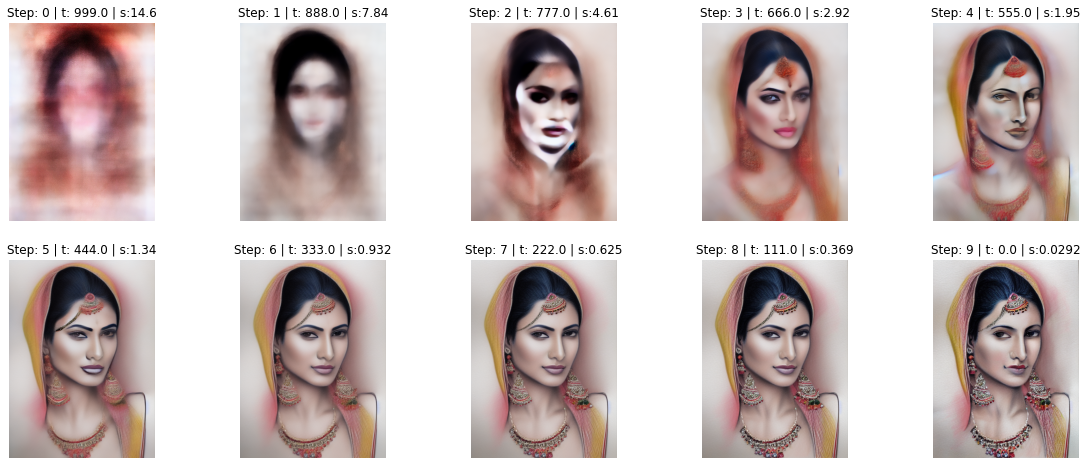

In [98]:
viz_response(gen_response)

**Here we can see the result at each timesteps**

We we have 1000 timesteps by default when training. But we reduce that to a minimum amount here. But at the end we will go through the whole timestep.

As you can see here, the final result is not the best one over here. Inspecting these will give us the result that we are looking for.

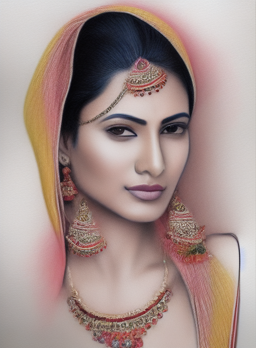

In [100]:
# To me, this is the best looking result
decode_latent(gen_response[2][6], scale_factor=0.5)

## Let's increase the number of steps

In [101]:
gen_response = gen(prompt, seed=23, steps=50, height=700)

0it [00:00, ?it/s]

In [102]:
images = get_images(gen_response)

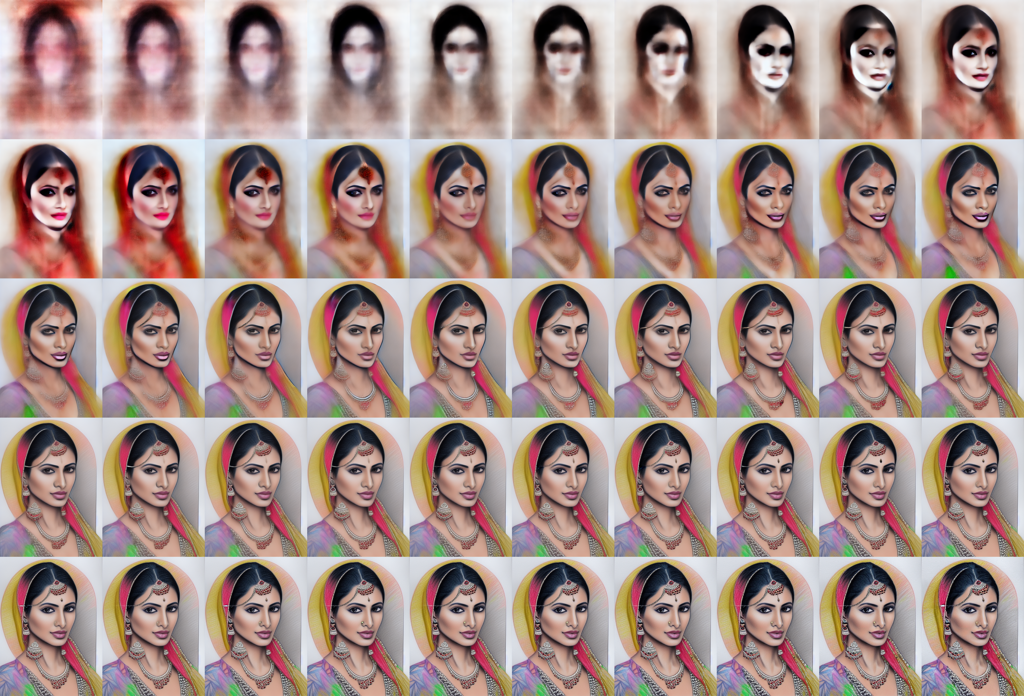

In [103]:
__d(images, rows=5, resize_factor=0.2)

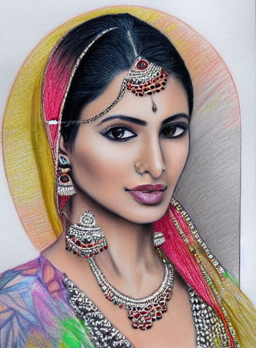

In [107]:
# In this case the final one looks better. But we don't need to go this amount of steps
decode_latent(gen_response[2][-1], scale_factor=0.5)

**As you can see, it's hard to tell which one is better.**

## Let's try 30 steps

In [129]:
gen_response = gen(prompt, seed=23, steps=30, height=700)

0it [00:00, ?it/s]

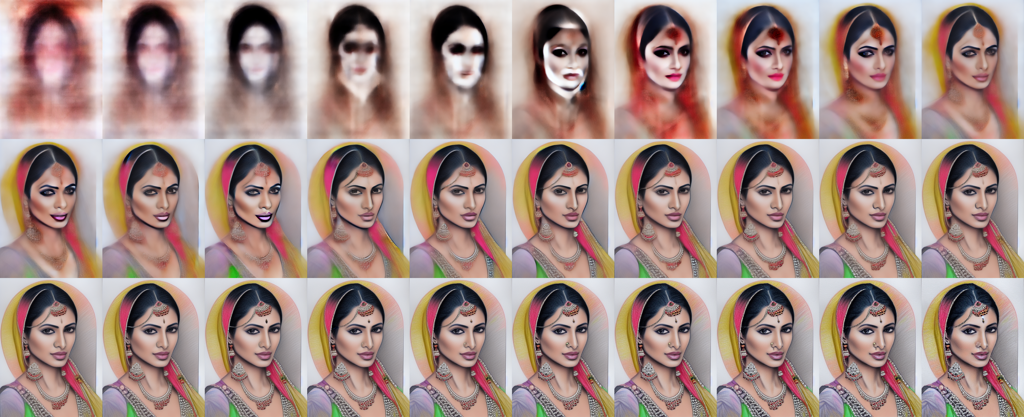

In [130]:
images = get_images(gen_response)
__d(images, rows=3, resize_factor=0.2)

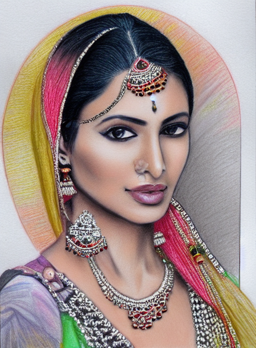

In [131]:
## Now, it looks similar to the above
decode_latent(gen_response[2][-1], scale_factor=0.5)

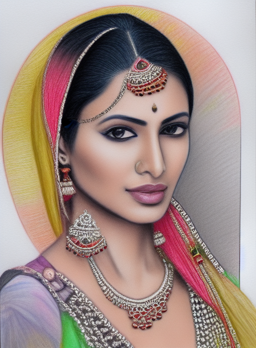

In [134]:
decode_latent(gen_response[2][23], scale_factor=0.5)